In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pydot
%matplotlib inline

In [6]:
class GraphLoader:
    def __init__(self):
        self.graph = None
        self.title = None
        
    def build_graph(self, 
                    dataframe: pd.DataFrame, 
                    columns: List, 
                    edge_list: List,
                    verbose: bool = True,
                    title: str = 'Unnamed'):
        self.title = title
        t0 = time()
        self.graph = nx.Graph(name = self.title)

        # Add Nodes to the graph.
        for column in columns:
            self.graph.add_nodes_from(dataframe[column].values, label=column)

        # Add remaining columns as Node attributes. Optional
        remaining = dataframe.columns.difference(columns)
        for node, data in self.graph.nodes(data=True):
            if data["label"] == "K":
                self.graph.nodes[node]["K"] = dataframe.loc[dataframe["K"] == int(node), remaining].squeeze().to_dict()

        # Add Edges.
        for _, row in dataframe.loc[:, columns].iterrows():
            for edge in edge_list:
                self.graph.add_edge(row[edge[0]], row[edge[1]])
        
        if verbose:
            print(f"FINISHED in {np.round(time() - t0, 3)} seconds.")
            print(nx.info(self.graph))
        
        return self.graph

    def draw_graph(self, graph: nx.Graph, node_colors: dict, node: str = None, radius: int = 1) -> None:
        def assign_colors(graph: nx.Graph) -> List:
            # Assign Colors to nodes
            colors = []
            for n, data in graph.nodes(data=True):
                node = data["label"]
                colors.append(node_colors.get(node, "white"))
            return colors

        f = plt.figure(figsize = (200,120), facecolor="none")
        ax = f.add_subplot()

        if not node:    
            1
        else:
            plt.title(f"Ego Graph around the node {node}, (radius={radius})")
            graph = nx.ego_graph(graph, node, radius = radius)
        
        colors = assign_colors(graph)
        #pos=nx.shell_layout(graph)
        #pos=nx.random_layout(graph)
        #pos=nx.nx_agraph.graphviz_layout(graph)
        pos=nx.nx_agraph.graphviz_layout(graph, prog="fdp")
        nx.draw_networkx(graph,pos, node_size = 15000, node_color = colors, with_labels = False,width=5.0,alpha=0.9)
        # Add an empty plot to set custom legends
        from matplotlib.lines import Line2D
        ax.scatter([],[])
        legend_elements = [
            Line2D([0], [0], marker='o', color='w', label='K', markerfacecolor = node_colors['K'], markersize=90),
            Line2D([0], [0], marker='o', color='w', label='S1', markerfacecolor = node_colors['S1'], markersize=85),
            Line2D([0], [0], marker='o', color='w', label='S2', markerfacecolor = node_colors['S2'], markersize=85),
            Line2D([0], [0], marker='o', color='w', label='S3', markerfacecolor = node_colors['S3'], markersize=85),
            Line2D([0], [0], marker='o', color='w', label='S4', markerfacecolor = node_colors['S4'], markersize=85),
            Line2D([0], [0], marker='o', color='w', label='S5', markerfacecolor = node_colors['S5'], markersize=85),
            Line2D([0], [0], marker='o', color='w', label='S6', markerfacecolor = node_colors['S6'], markersize=85),

        ]
        ax.legend(handles=legend_elements, loc='best',fontsize ='100')
        plt.savefig('fileName2.svg', transparent=True, bbox_inches='tight', pad_inches=0.0)
        plt.show()

In [7]:
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
target_column = 'K'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']

df_attrition = df_attrition.loc[:, selected_columns]

In [8]:
nodes = selected_columns[:] # Do not select Attrition as a feature node
edges = [("K","S1"),
         ("K","S2"),
         ("K","S3"),
         ("K","S4"),
         ("K","S5"),
         ("K","S6")]

node_colors = { # freestyle, update any color.
    "K": "dodgerblue", 
    "S1":"#A8D8B9", 
    "S2":"#A5DEE4", 
    "S3":"#FEDFE1",
    "S4":"#D7B98E",
    "S5":"#FB9966",
    "S6":"#81C7D4"
}

In [9]:
graph_loader = GraphLoader()
demo_graph = graph_loader.build_graph(
            dataframe = df_attrition.loc[:, selected_columns[:]],
            columns = nodes, 
            edge_list = edges,
            verbose = True,
            title = 'Multilingual Out of Vocabulary Terms relationship'
        )
# graph_loader.draw_graph(demo_graph, node_colors, node = 5, radius = 2) # show only the nodes that are at a distance of 2 edges from the employee 5.
graph_loader.draw_graph(demo_graph, node_colors) # Show the whole graph

FINISHED in 0.053 seconds.
Graph named 'Multilingual Out of Vocabulary Terms relationship' with 502 nodes and 693 edges


/tmp/ipykernel_1079831/2463267907.py:33: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(self.graph))


In [34]:
len(demo_graph)

502

In [27]:
def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(demo_graph.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

In [28]:
all_nodes = list(demo_graph.nodes())

random_walks = []

for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,30))

100%|██████████| 502/502 [00:00<00:00, 21658.15it/s]


In [29]:
len(random_walks)

2510

In [30]:
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

In [31]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 12,vector_size=128)

model.build_vocab(random_walks, progress_per=2)

In [32]:
model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

(255953, 286000)

In [37]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
def save_model(model, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = 128
        w = 30
        n = 50
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}_deepwalk.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}_deepwalk.pkl"
        # Save only the embeddings in a txt file.
        model.wv.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")

In [38]:
save_model(model, save_to = EMBEDDINGS_DIR, prefix = "K")

Model and embeddings saved to: /home/gujiakai/Dropbox/毕业论文/实验/embeddings/K_model_128_30_50_deepwalk.pkl


In [5]:
import matplotlib.pyplot as plt
from time import time

from gem.utils import graph_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr

from gem.embedding.gf import GraphFactorization
from gem.embedding.hope import HOPE
from gem.embedding.lap import LaplacianEigenmaps
from gem.embedding.lle import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
from gem.embedding.sdne import SDNE
from argparse import ArgumentParser


In [6]:
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA

from pandas_profiling import ProfileReport


In [7]:
CWD = Path().cwd()
EMBEDDINGS_DIR = CWD / 'embeddings'
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)
SEED = 12

class VectorizerConfig:
    dimensions = 128
    walk_length = 30
    num_walks = 50
    window = 10
    min_count = 1
    batch_words = 100

class NodeEmbedding:

    def __init__(self) -> None:
        self.vectorizer = None
        self.model = None
        
    def generate_random_walks(self, graph: nx.Graph, **params) -> None:
        self.vectorizer = Node2Vec(graph, **params)
        # return self.vectorizer

    def fit(self, **params) -> gensim.models.Word2Vec:
        if self.vectorizer is None:
            raise Exception("No random walks. Generate Random walks by calling generate_random_walks() method first.")
        self.model = self.vectorizer.fit(**params)
        
        return self.model
    def save_model(self, model: gensim.models.Word2Vec, save_to: Path = EMBEDDINGS_DIR, prefix: str = None) -> None:
        d = VectorizerConfig.dimensions
        w = VectorizerConfig.walk_length
        n = VectorizerConfig.num_walks
        embeddings_filename = f"{prefix}_embeddings_{d}_{w}_{n}.txt"
        model_filename = f"{prefix}_model_{d}_{w}_{n}.pkl"
        # Save only the embeddings in a txt file.
        self.model.wv.save_word2vec_format(str(EMBEDDINGS_DIR/embeddings_filename))
        # Save the entire model.
        self.model.save(str(EMBEDDINGS_DIR/model_filename))
        print(f"Model and embeddings saved to: {str(EMBEDDINGS_DIR/model_filename)}")
    def load_model(self, model_filename: str = None, load_from: Path = EMBEDDINGS_DIR) -> gensim.models.Word2Vec:
        if Path(EMBEDDINGS_DIR / model_filename).exists():
            print("Loaded Model: ", model_filename)
            with Path(EMBEDDINGS_DIR / model_filename).open(mode="r+b") as file:
                self.model = pickle.load(file)
        else:
            raise FileNotFoundError(f"NOT found: {EMBEDDINGS_DIR / model_filename}")
        
        return self.model


In [9]:
import multiprocessing
from pathlib import Path
import pickle
from time import time
from typing import List, Dict, Set, Tuple
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.datasets import load_iris
import numpy as np
import gensim
import networkx as nx
from node2vec import Node2Vec
from sklearn.decomposition import PCA
from pandas_profiling import ProfileReport
attrition = 'test.csv'
df_ac = pd.read_csv(attrition,encoding='utf-8')
embedder = NodeEmbedding()
model2 = embedder.load_model(r"K_model_128_30_50.pkl", load_from = EMBEDDINGS_DIR)

Loaded Model:  K_model_128_30_50.pkl


In [10]:
with open(r'embeddings/K_embeddings_128_30_50.txt', 'r',encoding='UTF-8') as embeddings_file:
    embeddings = embeddings_file.readlines()

In [11]:
# This function is requred since embeddings are out of order with the target. They were not matched correctly.
def align_features_and_target(df: pd.DataFrame, embeddings_file: str = None):
    vectors = []
    with Path(EMBEDDINGS_DIR / embeddings_file).open(mode="r",encoding='UTF-8') as file:
        results = file.readlines()
        for person in df["K"].values:
            for line in results[1:]:
                if line.split()[0] == str(person):
                    vectors.append(line.split()[1:])
    
    return np.array(vectors).astype(np.float64)

In [12]:
%%time
target_column = 'word'
selected_columns = ['K', 'S1', 'S2', 'S3', \
                    'S4', 'S5','S6']
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)
df_attrition = df_attrition.loc[:, selected_columns]
embeddings_filename = r"K_embeddings_128_30_50.txt"
feature_vectors = align_features_and_target(df_attrition, embeddings_file = embeddings_filename)
attrition_data = 'cbd.csv'
df_attrition = pd.read_csv(attrition_data)


CPU times: user 602 ms, sys: 7.8 ms, total: 609 ms
Wall time: 611 ms


Embedding dimension greater than 2, use tSNE to reduce it to 2


/Users/gabrielpondc/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/gabrielpondc/miniforge3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


NetworkXError: Node '-0.08547448, -0.29826584, -0.14741431, -0.67061037, -0.43497878, -0.38970268, -0.19331034, 0.0026911893, -0.14017418, -0.3710046, 0.19588524, 0.50693357, -0.40660346, 0.060307745, 0.4046258, -0.62973624, 0.11785334, -0.17953649, 0.05160977, -0.095493965, -0.18132052, 0.03826847, -0.1944767, -0.8787426, -0.052537657, 0.23939374, 0.61991715, 0.87798643, 0.22267313, -0.29736802, 0.028789824, -0.30809578, -0.0542155, -0.25352523, -0.25583473, -0.08532951, 0.28817376, 0.41289523, -0.00792686, 0.24107456, -0.20131549, 0.3377247, -0.25690502, 0.35726756, 0.027287206, -0.40293846, -0.54056203, -0.28486973, -0.029724529, -0.47154206, -0.3967071, -0.4742465, -0.005546905, -0.50885016, -0.061332688, 0.07627737, 0.12908617, 0.19868691, 0.5408949, -0.4623319, 0.13502872, 0.1309458, -0.26053345, -0.009056642, 0.08146737, -0.14192095, -0.20352887, 0.21550697, 0.19168872, -0.29205415, 0.26351216, 0.24171916, 0.025810005, -0.55607706, -0.40277648, 0.13517939, -0.27300778, 0.3711192, -0.193878, 0.02004339, -0.36554146, 0.48420388, 0.0878743, 0.34118977, 0.03527869, 0.06615776, 0.24636766, -0.030541956, -0.30129728, -0.05087695, -0.08543088, 0.25910518, 0.16375847, 0.14950982, 0.41354564, -0.09212178, 0.039013565, 0.12550597, -0.39747158, 0.0011751303, -0.0302062, -0.28866524, -0.1901337, -0.2015753, 0.11327507, 0.46685705, -0.49245948, 0.06320734, -0.3105893, -0.20835456, 0.17934407, -0.52467066, 0.19670442, -0.10700878, -0.032256693, 0.5803727, 0.30203456, 0.26631632, -0.23506074, -0.23485185, 0.2501363, -0.12184304, 0.6253184, -0.035855155, 0.050049763, -0.15232724, -0.38403606, -0.020263184, -0.5847818, -0.004061971, -0.09157497, -0.4583943, -0.34568977, -0.52104604, -0.25861678, -0.117276, 0.09799441, 0.15111157, 0.3134129, -0.10316217, 0.040958494, 0.2389556, 0.17087452, -0.70924014, -0.001072801, -0.26048806, -0.0540118, -0.42857033, 0.42508703, 0.0016576943, 0.070508994, 0.04336412, 0.00092854566, -0.00027608735, 0.040260985, 0.2957077, 0.0015368146, -0.14539924, 0.12009415, -0.21632099, -0.16827787, 0.012367013, -0.26745015, 0.016989142, -0.016897155, 0.0875287, 0.020095015, 0.13754281, 0.21871457, 0.1386973, 0.1382741, -0.059942845, -0.13604516, -0.2653919, -0.2131206, -0.1908882, 0.36786342, 0.5130381, -0.1351802, 0.0793475, -0.39795962, 0.42081177, 0.3715465, 0.35093012, 0.12619488, 0.35592395, -0.40973133, -0.19444618, 0.18313268, 0.07849345, -0.25149447, -0.15154907, -0.2326549, 0.053796984, 0.09788425, 0.07247626, -0.02296063, -0.37131947, 0.0594042, 0.09914632, -0.16609015, 0.34075087, -0.12332687, 0.0005157145, 0.14297669, 0.017582132, -0.008779151, -0.12335509, 0.028752109, -0.13830797, -0.015183254, 0.018969852, -0.15514384, -0.20015176, 0.41659614, 0.4606939, -0.19941185, 0.012086859, 0.18714122, -0.17984743, 0.39554515, -0.21936855, 0.22323571, -0.4914505, -0.13813391, 0.017122291, -0.09105322, -0.32170448, 0.056053903, 0.02643442, 0.28093007, -0.16845793, -0.054187518, 0.28471726, 0.07457285, 0.14122358, 0.019835977, -0.31870613, 0.13467562, -0.34367275, 0.16879731, 0.4887708, -0.24816054, 0.41746026, 0.31506085, 0.17307363, 0.044022985, -0.31272265, 0.068612866, -0.15236238, 0.0671384, 0.3666283, 0.05042359, -0.24060361, -0.22770517, -0.11951465, -0.04880576, 0.019174015, 0.2776341, 0.5573643, 0.39455283, -0.06596572, -0.38140762, -0.040391847, 0.16734867, 0.22110373, 0.5233019, -0.244626, -0.06581722, -0.23032989, -0.1740666, -0.26465023, -0.22275618, 0.43023762, -0.026344901, 0.0849443, 0.06791598, 0.15605208, -0.29888138, -0.17934243, -0.13411514, -0.08885195, -0.15275909, -0.3600689, 0.08731703, -0.014200481, -0.072012715, 0.019505868, 0.10770646, -0.1055515, -0.14581163, 0.21632844, 0.22605777, -0.32623723, -0.12906912, 0.25288722, -0.22108723, -0.12618136, -0.6181268, 0.28843206' has no position.

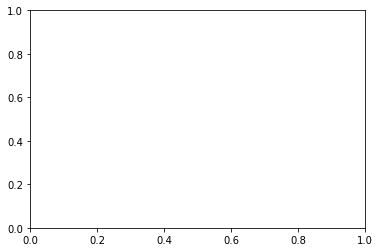

In [19]:
viz.plot_embedding2D(model2.wv.vectors, di_graph=demo_graph, node_colors=None)

plt.show()
plt.clf()